In [ ]:
!pip install numpy
!pip install matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

Performance of spectrum sensing detectors under Laplacian noise using real samples of signal and noise

Parameter value: -20


<ipython-input-20-715376a01647>:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a[row, 0] = np.random.normal(np.sqrt(K / (K + 1)), np.sqrt(1 / (K + 1)), 1)
<ipython-input-20-715376a01647>:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ted_h0[i] = SUM0
<ipython-input-20-715376a01647>:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ted_h1[i] = SUM1
<ipython-input-20-715376a01647>:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Parameter value: -15
Parameter value: -10
Parameter value: -5
Parameter value: 0
Parameter value: 5
Parameter value: 10
Parameter value: 15
Parameter value: 20
[1412.9218995  1414.51110301 1432.02482398 ... 1443.95782114 1428.87949104
 1432.10646102]
Number of SUs:                  m = 6
Number of samples per SU:       n = 300
Configured SNR in dB:           SNR = -8
Measured SNR in dB:             SNR = -7.924607845477198
Number of sensing rounds:       100000
Coverage radius, r:             1 m
PU tx coordinates:              ( 1 , 1 ) m
Path-loss exponent:              2.5
Random K (1=yes, 0=no):          1
Rice factor K, dB: mean, stdev = 20 , 4.13
Noise variation fraction:        0.5
PU signal (0=Gaussian,1=QPSK):   0
Number of Monte Carlo runs:      100000
Noise type:                      Laplacian
Reference CFAR:                 Pfa = 0.1
Varying parameter values:        [-20, -15, -10, -5, 0, 5, 10, 15, 20]


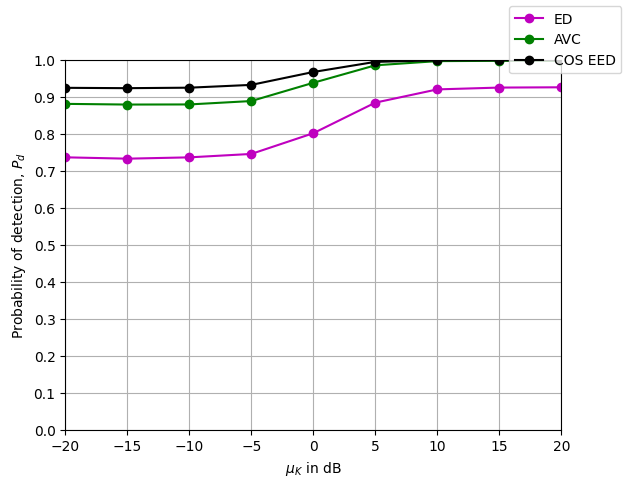

In [20]:
# System parameters

Laplace = 1 # Variable which enables (1) or not (0) Laplacian noise
m = 6 # Number of secondary users (SUs)
SNR = -10 # Average signal-to-noise ratio over all SUs, dB
runs = 100000 # Number of Monte Carlo runs
eta = 2.5 # Path loss exponent
r = 1 # Coverage radius, m (normalized)
d0 = 0.001*r # Reference distance for path loss calculation, m
P_txPU = 5 # Primary user (PU) transmitted power, W
xPU = 1*r # x-coordinate of the PU transmitter, m. Equal to y-coordinate
n = 300 # Number of samples collected per SU
T = n/10 # Number of samples per QPSK PU transmitted symbol (n/T must be integer)
rho = 0.5 # Fraction of noise power variations about the mean
meanK = 1.88 # Mean of Rice factor (K), dB. K is variable over the runs and SUs
sdK = 4.13 # Standard deviation of K over the runs and SUs, dB
randK = 1 # Variable which enables K as a random variable if randK = 1; otherwise, randK = 0, and K is fixed and equal to meanK
PUsignal = 0 # PU signal: "0" = iid Gaussian (models its envelope); "1" = niid (T>1) or iid (T=1) QPSK
Npt = 40 # Number of points on the ROCs
Pfa = 0.1 # Reference probability of false alarm (Pfa) for threshold computation
NU = 0 # Variables which enables (1) or not (0) noise uncertainty
k = [1, 2, 3, 4, 5, 6]   # Vector which contains the indexes of interest for COS scheme (considering m = 6)
p = 0.5

# Obs: for urban area: meanK = 1.88, sdK = 4.13. For rural area: meanK = 2.63, sdK = 3.82

# In this work, we will reproduce only the impact on the performance caused by the variation of meanK
Parameter = [-20, -15, -10, -5, 0, 5, 10, 15, 20] # Values assigned to meanK. Each one will be executed "runs" times
SNR = -8 # Value of SNR in which the best detector has Pd = 0.9 at the mid-value of the system parameter being analyzed
Flag = 1 # Flag to control which parameter would be analyzed

snr = np.zeros((runs,len(Parameter)))
snr2 = np.zeros((runs,len(Parameter)))
CDF_Ted_h1 = np.zeros(len(Parameter)) # Empirical CDF for ED
CDF_Tavc_h1 = np.zeros(len(Parameter)) # Empirical CDF for AVC
CDF_Tcoseed_h1 = np.zeros(len(Parameter)) # Empirical CDF for COS EED

for loop in range(len(Parameter)): # for loop which determines the correspondent value of the parameter
    if Flag == 1:
        meanK = Parameter[loop]
        print('Parameter value: ' + str(Parameter[loop]))

    # Pre-allocation of variables
    Prx_measured = np.zeros(runs) # Received power measured
    Pnoise_measured = np.zeros(runs) # Noise power measured
    Ted_h0 = np.zeros(runs) # Energy detector test statistic under hypothesis H0 (absence of primary signal)
    Ted_h1 = np.zeros(runs) # Energy detector test statistic under hypothesis H1 (presence of primary signal)
    Tavc_h0 = np.zeros(runs) # Absolute value cumulating detector test statistic under hypothesis H0 (absence of primary signal)
    Tavc_h1 = np.zeros(runs) # Absolute value cumulating detector test statistic under hypothesis H1 (presence of primary signal)
    Tcoseed_h0 = np.zeros(runs) # COS EED detector test statistic under hypothesis H0 (absence of primary signal)
    Tcoseed_h1 = np.zeros(runs) # COS EED value cumulating detector test statistic under hypothesis H1 (presence of primary signal)
    v0 = np.zeros(m)
    v1 = np.zeros(m)
    v_h0 = np.zeros(m)
    v_h1 = np.zeros(m)

    for i in range(runs): # Monte Carlo runs loop
      # SUs coordinates inside a circular area of radius r
      rr = np.sqrt(np.random.rand(m, 1)) # Generating "m" random values between 0 and 1. They are allocated in the "rr" vector. Of each value it is performed the squared root. Refers to the distance between the center and the random point generated
      theta = 2*np.pi*np.random.rand(m, 1) # Generating a random angle value inside a circular area of radius r
      SU = np.hstack((rr * np.cos(theta), rr * np.sin(theta)))
      SU *= r

      # Distances from the PU tx to the SUs
      d_pu = np.zeros((m, 1))
      for j in range(m):
          d_pu[j] = np.linalg.norm(SU[j] - [xPU, xPU])  # Distances from the SUs to the PU at [xPU, xPU]

      # SU received signal powers (from PU tx)
      P_rxSU = P_txPU * (d0 / d_pu) ** eta  # P_rxSU_dBm = 10 * np.log10(P_rxSU / 0.001)
      if rho > 0:
          SNRcorrectionFactor = np.log((1 + rho) / (1 - rho)) / (2 * rho)
          Gamma = np.sum(P_rxSU) * SNRcorrectionFactor / m  # Average SNR for Sigma2_avg = 1, rho > 0.
      else:
          SNRcorrectionFactor = 1
          Gamma = np.sum(P_rxSU) / m  # Average SNR for Sigma2_avg = 1, rho = 0.

      # Corrected average noise variance
      Sigma2_avg = Gamma / (10 ** (SNR / 10))

      # Noise variances (m x 1) variable over all sensing rounds
      U = np.random.uniform(-1, 1, (m, 1))
      # Calculate noise variances across the SUs
      Sigma2 = (1 + rho * U) * Sigma2_avg

      a = np.zeros((m, 1))
      for row in range(m):
        if randK == 1:
          K = 10 ** (np.random.randn(1) * sdK + meanK) / 10  # Variable K
        else:
          K = 10 ** (meanK / 10)  # Fixed K
        a[row, 0] = np.random.normal(np.sqrt(K / (K + 1)), np.sqrt(1 / (K + 1)), 1)

      # Calculate distance-dependent channel gains
      g = np.sqrt(P_rxSU / P_txPU)  # Distance-dependent channel gains

      # Rescale the channel vector according to the gains
      h = a * g

      # Initialize Gaussian noise matrices
      W0 = np.zeros((m, n))
      W1 = np.zeros((m, n))

      # Generate Gaussian noise for each row
      for j in range(m):
        W0[j, :] = np.random.normal(0, np.sqrt(Sigma2[j]), n)
        W1[j, :] = np.random.normal(0, np.sqrt(Sigma2[j]), n)

      # Initialize Laplacian noise matrices
      L0 = np.zeros((m, n))
      L1 = np.zeros((m, n))

      # Generate Laplacian noise for each row
      for j in range(m):
        b = np.sqrt(Sigma2[j] / 2)
        L_re0 = np.random.exponential(scale=b, size=n) - np.random.exponential(scale=b, size=n)
        L0[j, :] = L_re0
        L_re1 = np.random.exponential(scale=b, size=n) - np.random.exponential(scale=b, size=n)
        L1[j, :] = L_re1
      # Gaussian or Laplacian noise selection
      W0 = W0*(1-Laplace)+L0*Laplace
      W1 = W1*(1-Laplace)+L1*Laplace

      # PU signal (n x 1):
      if PUsignal == 0: # Gaussian envelope PU signal (1 x n)
        S = np.random.normal(0, 1, (1,n)) # Generate normally distributed random numbers
        arrayP_txPU = np.full((1,n), P_txPU) # Generating a vector with the same length of S that will be transformed into a diagonal matrix
        S = (np.dot(S.T,np.diag(np.sqrt(arrayP_txPU)))).T
      elif PUsignal == 1: # QPSK PU signal (1 x n) with T samples per symbol
        S = np.array([])
        for symb in range(n / T):
            symbol = (np.random.randint(2, size=1) * 2 - 1) * np.ones((1, T))
            S = np.concatenate((S, symbol), axis=1)
        S = (np.dot(S.T,np.diag(np.sqrt(arrayP_txPU)))).T

      # Measured SNR in each run and loop
      snr[i,loop] = np.mean(np.sum((np.abs(h*S)) ** 2,axis=1)/np.sum((np.abs(W0))**2,axis = 1)) # Correct
      snr2[i,loop] = np.mean(np.sum(np.abs(h*S) ** 2, axis = 1))/np.mean(np.sum(np.abs(W0) ** 2, axis = 1)) # Incorrect
      snr2[i,loop] = np.mean(np.sum(np.abs(h*S) ** 2, axis = 1))/np.mean(np.sum(np.abs(W0) ** 2, axis = 1))*SNRcorrectionFactor # Incorrect corrected

      # Received signal matrices under hypotheses H0 and H1 (mxn)
      X_h0 = W0
      X_h1 = h*S + W1

      # Energy Detector (ED):
      SUM0 = 0
      SUM1 = 0
      for c in range(m):
        if NU == 1:
          Sigma2[c] = Sigma2_avg
        SUM0 = SUM0 + np.sum(np.abs(X_h0[c,:]) ** 2)/(Sigma2[c])
        SUM1 = SUM1 + np.sum(np.abs(X_h1[c,:]) ** 2)/(Sigma2[c])
      Ted_h0[i] = SUM0
      Ted_h1[i] = SUM1

      # Absolute Value Cumulating (AVC):
      SUM0 = 0
      SUM1 = 0
      for c in range(m):
        if NU == 1:
          Sigma2[c] = Sigma2_avg
        SUM0 = SUM0 + np.sum(np.abs(X_h0[c,:]))/(np.sqrt(Sigma2[c]))
        SUM1 = SUM1 + np.sum(np.abs(X_h1[c,:]))/(np.sqrt(Sigma2[c]))
      Tavc_h0[i] = SUM0
      Tavc_h1[i] = SUM1

      # Combining with Order Statistics Enhanced Energy Detector (COS EED):
      SUM0 = 0
      SUM1 = 0
      for c in range(m):
          v0[c] = np.sum(np.abs(X_h0[c, :])**p) / (np.sqrt(Sigma2[c])**p)
          v1[c] = np.sum(np.abs(X_h1[c, :])**p) / (np.sqrt(Sigma2[c])**p)
      v_h0 = np.sort(v0)
      v_h1 = np.sort(v1)
      for c in range(m):
          if k[c] == c+1:
              SUM0 += v_h0[c]
              SUM1 += v_h1[c]
      Tcoseed_h0[i] = SUM0
      Tcoseed_h1[i] = SUM1

    # Empirical Probability of Detection (Pd)
    # ED:
    Th0 = Ted_h0
    Th1 = Ted_h1
    Z = np.sort(Th0)
    Gamma = Z[int((1-Pfa)*runs)]
    aux_h0 = 0
    aux_h1 = 0
    for ii in range(runs):
      if Th1[ii] < Gamma:
        aux_h1 = aux_h1 + 1
    CDF_Ted_h1[loop] = aux_h1/runs

    # AVC
    Th0 = Tavc_h0
    Th1 = Tavc_h1
    Z = np.sort(Th0)
    Gamma = Z[int((1-Pfa)*runs)]
    aux_h0 = 0
    aux_h1 = 0
    for ii in range(runs):
      if Th1[ii] < Gamma:
        aux_h1 = aux_h1 + 1
    CDF_Tavc_h1[loop] = aux_h1/runs

    # COS EED
    Th0 = Tcoseed_h0
    Th1 = Tcoseed_h1
    Z = np.sort(Th0)
    Gamma = Z[int((1-Pfa)*runs)]
    aux_h0 = 0
    aux_h1 = 0
    for ii in range(runs):
      if Th1[ii] < Gamma:
        aux_h1 = aux_h1 + 1
    CDF_Tcoseed_h1[loop] = aux_h1/runs

print(Tcoseed_h1)

# Summary of main parameters
if Laplace == 1:
    str_val = "Laplacian"
else:
    str_val = "Gaussian"

# alpha = 0.05  # confidence level
# Pd_hat, CI = binom.interval(1 - alpha, runs, runs / 2)  # (1-alpha)% Confidence interval

print('Number of SUs:                  m =', m)
print('Number of samples per SU:       n =', n)
print('Configured SNR in dB:           SNR =', SNR)
print('Measured SNR in dB:             SNR =', 10 * np.log10(np.mean(snr)))
print('Number of sensing rounds:      ', runs)
print('Coverage radius, r:            ', r, 'm')
print('PU tx coordinates:              (', xPU, ',', xPU, ') m')
print('Path-loss exponent:             ', eta)
print('Random K (1=yes, 0=no):         ', randK)
print('Rice factor K, dB: mean, stdev =', meanK, ',', sdK)
print('Noise variation fraction:       ', rho)
print('PU signal (0=Gaussian,1=QPSK):  ', PUsignal)
print('Number of Monte Carlo runs:     ', runs)
print('Noise type:                     ', str_val)
# print('Conf. interval @ Pd=0.5:   CI = ', CI)
print('Reference CFAR:                 Pfa =', Pfa)
print('Varying parameter values:       ', Parameter)

# Plots
ped = plt.plot(Parameter, (1 - CDF_Ted_h1), 'm-o')
pavc = plt.plot(Parameter, (1 - CDF_Tavc_h1), 'g-o')
pcoseed = plt.plot(Parameter, (1 - CDF_Tcoseed_h1), 'k-o')

plt.figlegend(['ED','AVC','COS EED'])
#plt.legend([ped, pavc], ['ED', 'AVC'], loc='lower left')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)

plt.ylabel('Probability of detection, $P_d$')
plt.xlabel('$\mu_K$ in dB')
plt.axis([min(Parameter), max(Parameter), 0, 1])
plt.show()